# ABC with the OpenCL RAMP model

Multi-paramter calibration of the RAMP model using Approximate Bayesian Computation

Based on [abc-1.ipynb](abc-1.ipynb). See that file for a more detailed technical description. This file calibrates on the location-specific hazard multipliers (e.g. to see if the algorithm can work out how hazardous the different location types are).

**Location hazards:

These are multipliers associated with locations (i.e. make some locations contribute more to the disease risk than others).

 - Home
  - Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0.
 - Retail:
  - Uniform between 0 and 1.
 - PrimarySchool: 1.0
  - Uniform between 0 and 1.
 - SecondarySchool: 1.0
  - Uniform between 0 and 1.
 - Work: 1.0
  - Uniform between 0 and 1.
 
**Individual hazards** 

These were mostly tested in [abc-1.ipynb](abc-1.ipynb), but might still vary.

 - Asymptomatic multiplier (`asymptomatic`)
  - This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). 
  
 - Presymptomatic and symptomatic multipliers (`presymptomatic` and `symptomatic`)
  - Are fixed at 1.0


## Import modules

See [abc-1.ipynb](abc-1.ipynb) for notes about installing these libraries

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Setup

Read parameters

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "


Open snapshot (i.e. an already-initialised model)

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model.

In [4]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16371


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [8]:
ITERATIONS = 100  # Number of iterations to run for ( Initially suggestes as 100)
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5 #Initially suggested as 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH,
    use_healthier_pop = False
)

In [9]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline, initially suggested as 10
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()

/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models:   0%|          | 0/10 [00:00<?, ?it/s]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 36052.


Running models:  10%|█         | 1/10 [00:11<01:43, 11.56s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 33877.


Running models:  20%|██        | 2/10 [00:24<01:36, 12.08s/it]

testing obesity arrays not equal
0.6317622812303595
0.6317622812303595
Running simulation 74295.


### Plot output summary data

#### Total counts of disease status

In [ ]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

In [ ]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [ ]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

In [ ]:
plot_disease_status_by_age(summaries0)

### Plots for MSOA geodata

Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

gis_data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(gis_data_dir)

devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)

Function to plot disease status by MSOA for a given timestep and status

In [ ]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Fitness

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [13]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

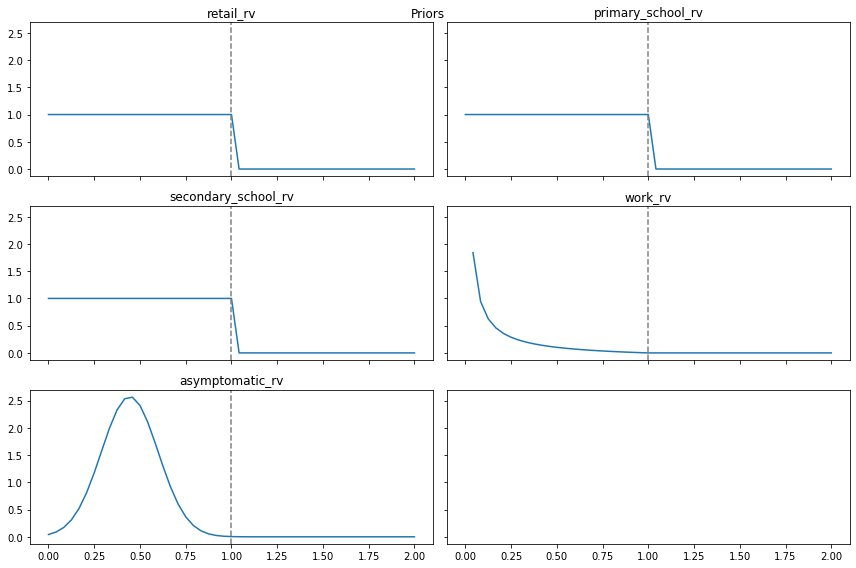

In [14]:
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0, "current_risk_beta": 0.03, "presymptomatic": 1.0, "symptomatic": 1.0 })
# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
#home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([1], [1.0])) for _ in range(2) )

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook). 
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75] 
asymptomatic_rv = pyabc.RV("norm", 0.444, 0.155)

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True)
x = np.linspace(0,2,49)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*')) 
for i, variable in enumerate([retail_rv, primary_school_rv, secondary_school_rv, work_rv,
                 asymptomatic_rv]):
    var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

#ax.legend()
fig.suptitle("Priors")
fig.tight_layout()


In [15]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    #presymptomatic = presymptomatic_rv,
    #symptomatic = symptomatic_rv, 
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    #current_risk_beta = current_risk_beta_rv
    )

(Optionally) define the transitions. The transitions ('perturbation kernels') define how the current population is transitioned to the next one. The default (multivariate normal) transition doesn't work for discrete values, so  we need a separate transition for the static parameters.

_Note: I experimented with this as a way to hack a constant variable by using a `DiscreteJumpTransition`, but it didn't work because the domain of transition was necessarily a single number (1) but the transition complained that it had nowhere to go_

### Initialise the ABC algorithm.

In [16]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
    )

Define observations

In [17]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [22]:
db_path = ("sqlite:///" + os.path.join(".", "abc-2.db"))

In [23]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=1, start_time=2022-07-06 17:23:54.342573>


### Run ABC

In [ ]:
history = None
fname = "./abc-2.pkl"

if LOAD_PICKLES and os.path.isfile(fname):
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    history = abc.run(max_nr_populations=2) 
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

### Algorithm diagnostics

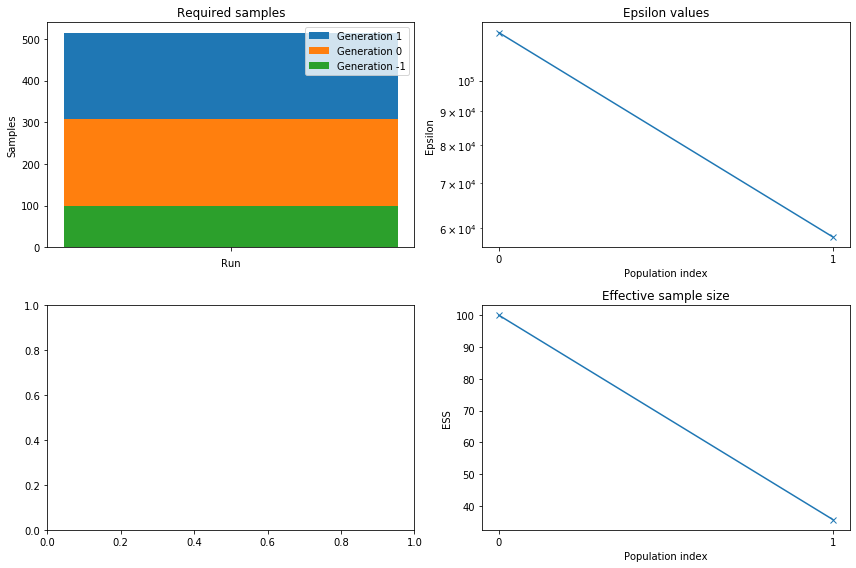

In [26]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

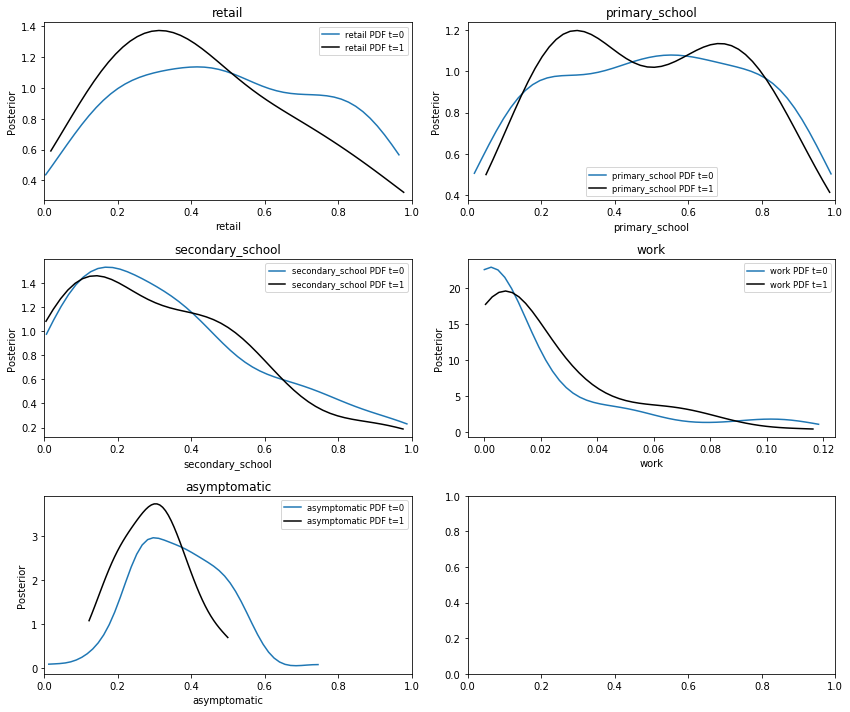

In [27]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

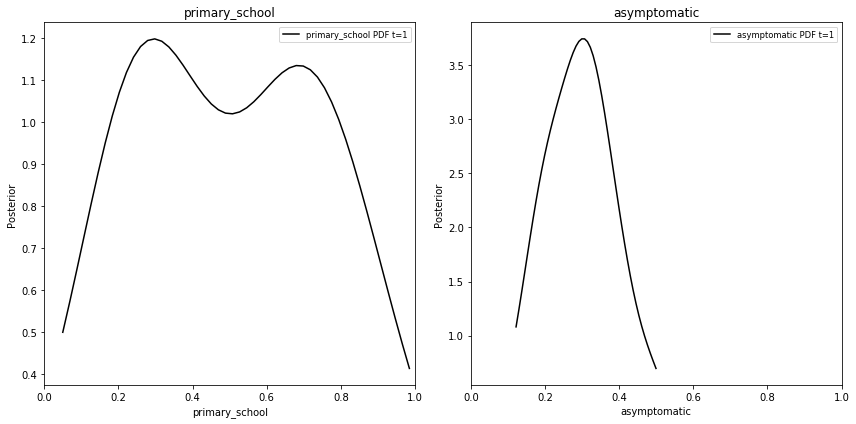

In [33]:
# As above but only show two parameters (for a Turing presentation)
fig, axes = plt.subplots(1,2, figsize=(12,6))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(['primary_school', 'asymptomatic']):
    ax = axes.flat[i]
    t = history.max_t
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
        label=f"{param} PDF t={t}", 
        alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
        color= "black" if t==history.max_t else None # Make the last one black
    ) 
    if param!="work":
        ax.set_xlim(0,1)
    ax.legend(fontsize="small")
    ax.set_title(f"{param}")
fig.tight_layout()

In [34]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e58ef4490>,
      dtype=object)

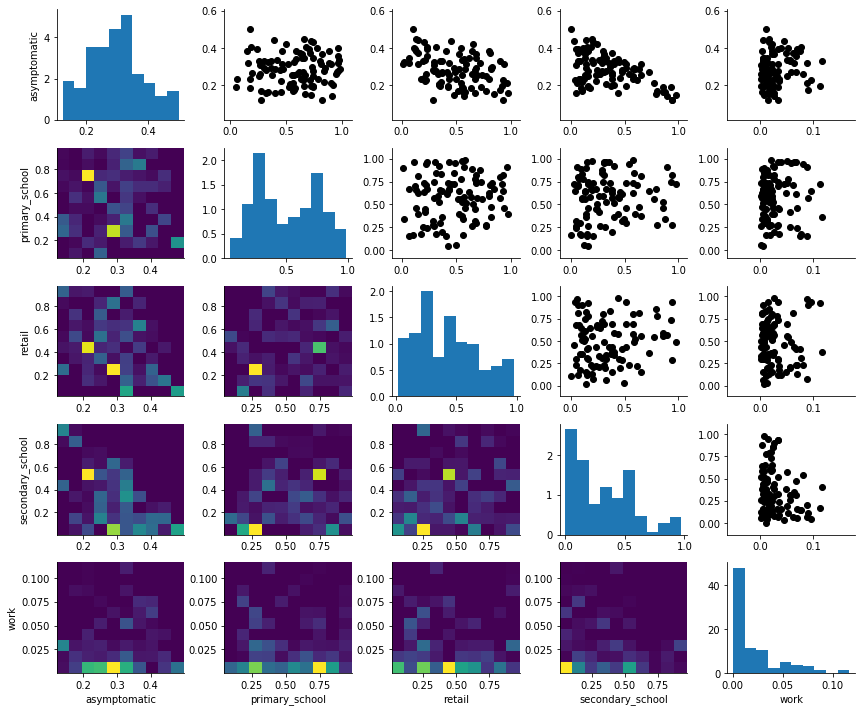

In [35]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [156]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,primary_school,retail,secondary_school,work,weight
0,1003,0.157417,0.660615,0.452352,0.924492,0.035427,0.139328
1,1041,0.145412,0.912497,0.549784,0.923724,0.011436,0.067097
2,1053,0.137994,0.723671,0.715171,0.941480,0.001309,0.062838
3,1062,0.167431,0.779117,0.687761,0.838511,0.002631,0.062114
4,1079,0.141848,0.630694,0.486667,0.961178,0.014832,0.044742
...,...,...,...,...,...,...,...
95,1013,0.075403,0.674643,0.406909,0.796626,0.217559,0.000436
96,1076,0.087805,0.648424,0.411532,0.697155,0.209814,0.000394
97,1043,0.080639,0.482845,0.469334,0.718640,0.224866,0.000333
98,1021,0.065044,0.660938,0.375025,0.773081,0.228484,0.000307


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [ ]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}
    
    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")
    
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Plot the individual results for each sample

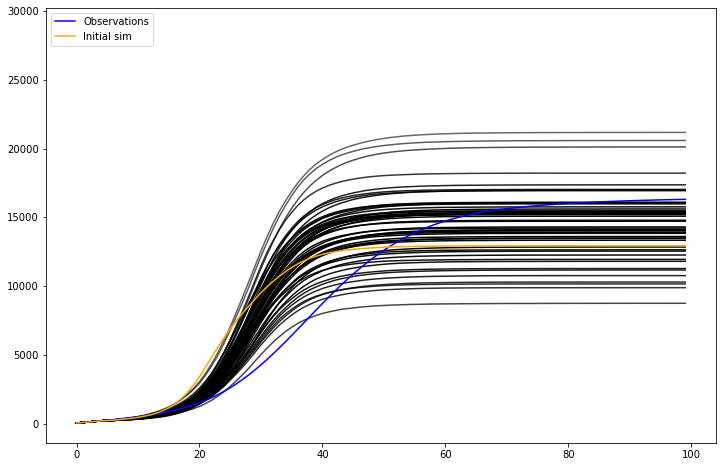

In [159]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness-min(_fitness))/(max(_fitness)-min(_fitness))

fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            #label=f"Particle {df.index[sample_idx[i]]}", 
            color="black", alpha = 1-fitness_norm[i]  # (1-x because high fitness is bad)
    )
    
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

del _fitness, fitness_norm

Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


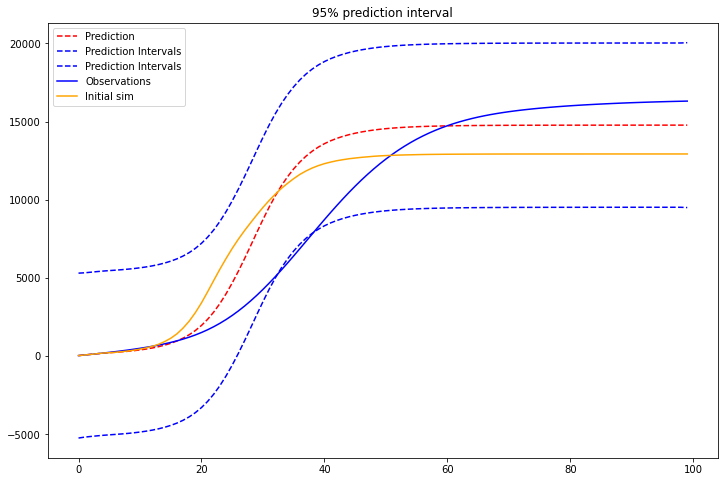

In [160]:
best_paramswo long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-100) for each particle
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');

Do a KDE plot with a logarithmic colour scale.

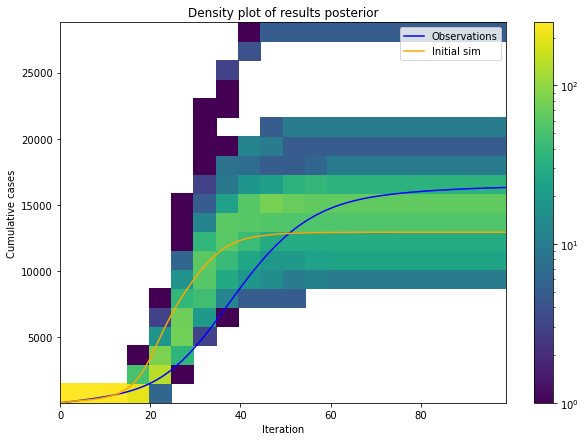

In [161]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1, figsize=(10,7))

h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5),
         norm=LogNorm())

ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [162]:
# Load samples if needed
#fitness_l, sim_l, obs_l, out_params_l, summaries_l = pickle_samples("load")

# Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
best_params

{'retail': 0.9882774231826963,
 'primary_school': 0.9722258402998256,
 'secondary_school': 0.8983346679981858,
 'work': 0.00495728111183362,
 'asymptomatic': 0.1434632342666732}

See how those parameters relate to the marginal posteriors

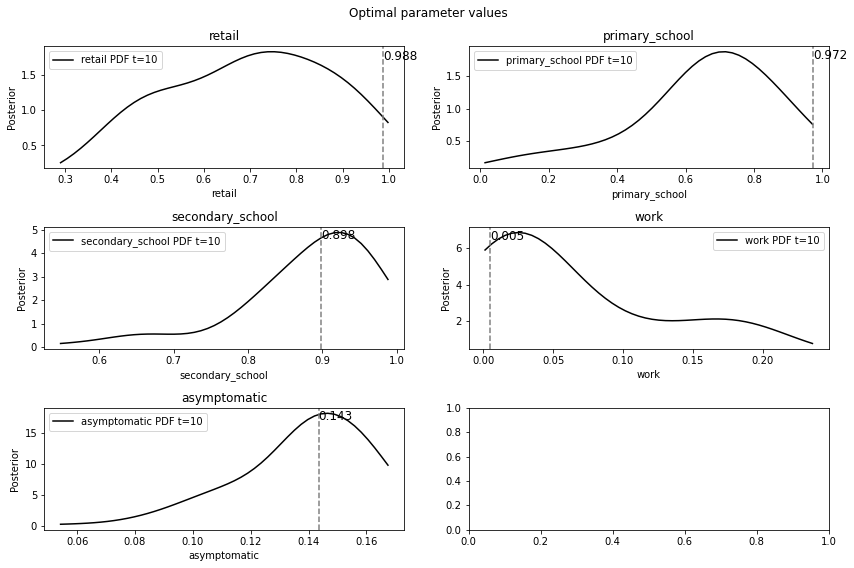

In [163]:
fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models: 100%|██████████| 5/5 [00:42<00:00,  8.44s/it]

.. finished, took 42.18s)


Ran Model with {'retail': 0.9882774231826963, 'primary_school': 0.9722258402998256, 'secondary_school': 0.8983346679981858, 'work': 0.00495728111183362, 'asymptomatic': 0.1434632342666732}
Fitness: 20429.23604053759


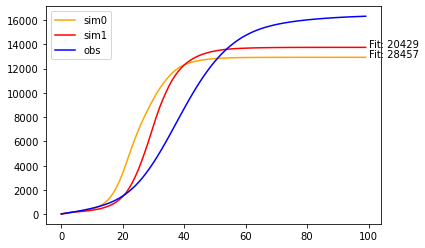

In [164]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0", color="orange")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1", color="red")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1)]: 
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

Run the model with arbitray parameters (to experiment)

In [165]:
best_params

{'retail': 0.9882774231826963,
 'primary_school': 0.9722258402998256,
 'secondary_school': 0.8983346679981858,
 'work': 0.00495728111183362,
 'asymptomatic': 0.1434632342666732}

Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/nick/research_not_syncd/git_projects/RAMP-UA/microsim/opencl/ramp/params.py:55: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models: 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]

.. finished, took 12.98s)


Ran Model with {'retail': 0.9, 'primary_school': 0.9, 'secondary_school': 0.9, 'work': 1e-05, 'asymptomatic': 0.124}
Fitness: 20429.23604053759


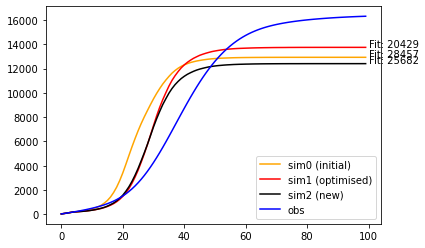

In [168]:
#OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness2, sim2, obs2, out_params2, summaries2) = OpenCLRunner.run_model_with_params_abc(
    {'retail': 0.9,
     'primary_school': 0.9,
     'secondary_school': 0.9,
     'work': 0.00001,
     'asymptomatic': 0.124},
    return_full_details=True)
#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0 (initial)", color="orange")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1 (optimised)", color="red")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries2), label="sim2 (new)", color="black")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1), (summaries2, fitness2) ]: 
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

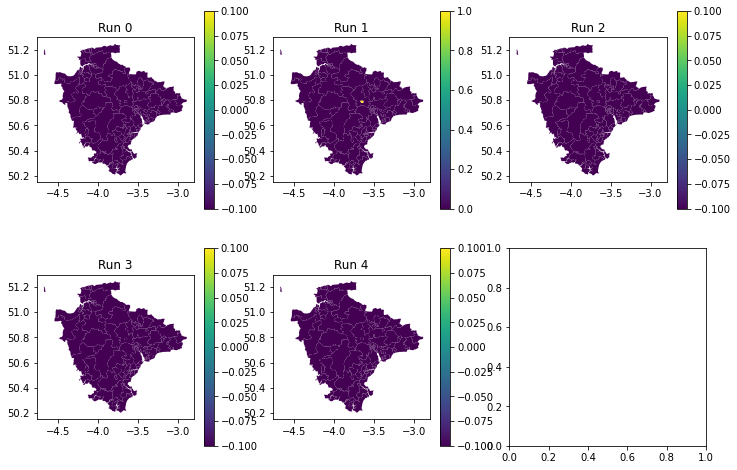

In [169]:
N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 